In [2]:
# import necessary libraries
import requests
import pandas as pd
import seaborn as sns
import plotly.express as px




In [3]:
import re
from collections import Counter
import matplotlib.pyplot as plt

# Récup depuis csv et Rajout d'un index 

In [4]:
dim_posts = pd.read_csv('instagram_all_posts.csv')

In [8]:
dim_posts["like_count"].describe()

count    3024.000000
mean       20.183862
std        17.691851
min         0.000000
25%         5.000000
50%        14.000000
75%        32.000000
max        90.000000
Name: like_count, dtype: float64

In [5]:
dim_insights = pd.read_csv('instagram_insights_reach_shares.csv')

In [6]:
dim_pics = pd.read_csv('dim_pics3.csv')

In [7]:
dim_insights["reach"].describe()

count    1884.000000
mean       18.269108
std       118.314263
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max      4734.000000
Name: reach, dtype: float64

In [11]:
dim_posts["like_count"].describe()

count    3022.000000
mean       20.185970
std        17.701201
min         0.000000
25%         5.000000
50%        14.000000
75%        32.000000
max        90.000000
Name: like_count, dtype: float64

In [ ]:
dim_insights = dim_insights.reset_index()
dim_posts = dim_posts.reset_index()
dim_pics = dim_pics.reset_index()

In [ ]:
dim_insights = dim_insights.rename(columns={'index': 'id_dim_insights'})
dim_posts = dim_posts.rename(columns={'index': 'id_dim_posts'})
dim_pics = dim_pics.rename(columns={'index': 'id_dim_pics'})

In [ ]:
#dim_insights.to_csv('dim_insights.csv', index=False)

In [ ]:
#dim_posts.to_csv('dim_posts.csv', index=False)
#dim_pics.to_csv('dim_pics.csv', index=False)

# exploration - distribution des termes

In [4]:
dim_pics = pd.read_csv('Schema/RAW/dim_pics.csv')
dim_posts = pd.read_csv('Schema/RAW/dim_posts.csv')
dim_insights = pd.read_csv('Schema/RAW/dim_insights.csv')

<Axes: xlabel='colorimétrie'>

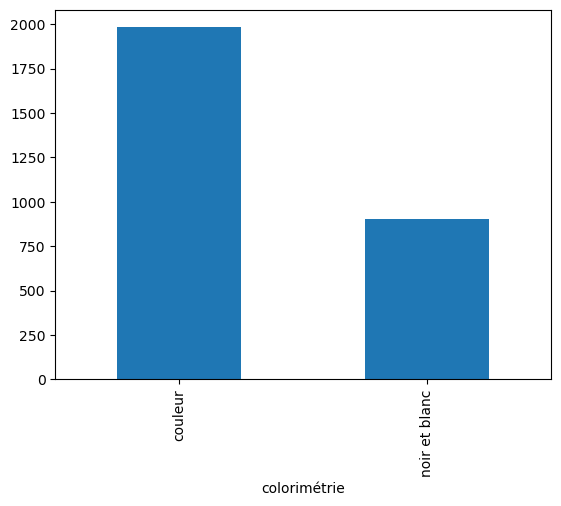

In [7]:
# distribution de la colorimetrie
dim_pics['colorimétrie'].value_counts().plot(kind='bar')

<Axes: xlabel='people'>

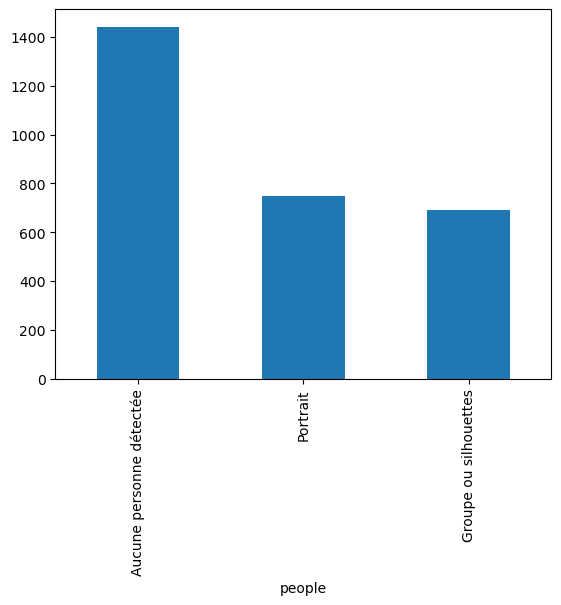

In [8]:
dim_pics['people'].value_counts().plot(kind='bar')

## Occurrence de termes dans caption

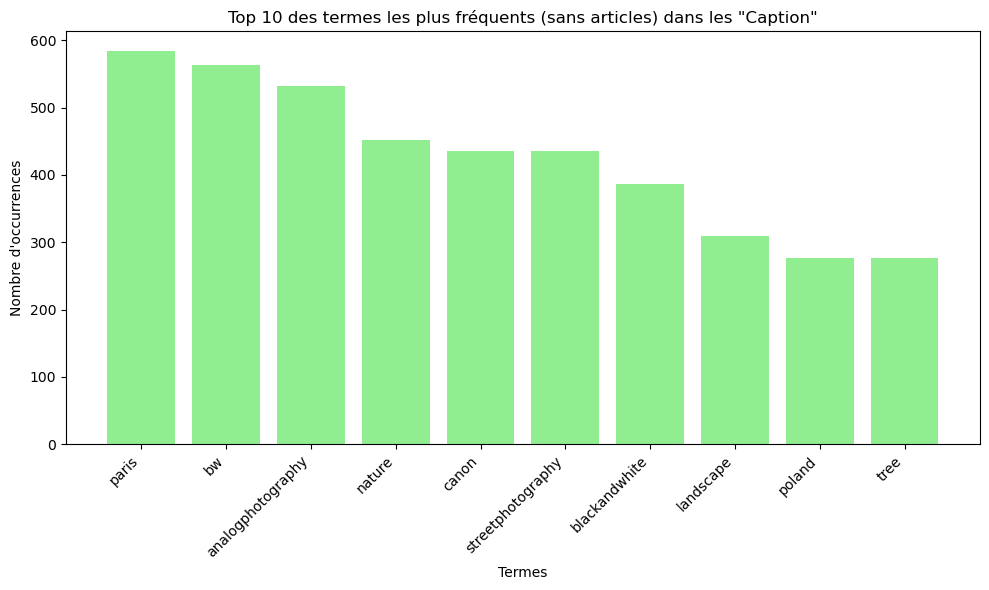

In [16]:

# Liste manuelle des articles et mots vides courants en français et en anglais
manual_stopwords = {
    'de', 'la', 'le', 'les', 'et', 'des', 'un', 'une', 'à', 'l', 'the', 'a', 'an', 'and', 'or', 'but', 'is', 'are', 'in', 'on', 'at', 'to', 'for'
}

# Nettoyer le texte : supprimer la ponctuation, convertir en minuscules et enlever les stopwords manuels
def clean_text_with_manual_stopwords(text):
    if isinstance(text, str):
        text = re.sub(r'[\W_]+', ' ', text)
        words = text.lower().split()
        return [word for word in words if word not in manual_stopwords]
    return []

# Appliquer le nettoyage à la colonne 'caption'
words_filtered = dim_posts['caption'].apply(clean_text_with_manual_stopwords).sum()

# Compter les occurrences de chaque terme (sans stopwords manuels)
word_counts_filtered = Counter(words_filtered)

# Extraire le top 10 des termes les plus fréquents
top_10_words_filtered = word_counts_filtered.most_common(10)

# Créer un DataFrame pour le top 10
top_10_df_filtered = pd.DataFrame(top_10_words_filtered, columns=['Term', 'Count'])

# Générer l'histogramme
plt.figure(figsize=(10, 6))
plt.bar(top_10_df_filtered['Term'], top_10_df_filtered['Count'], color='lightgreen')
plt.title('Top 10 des termes les plus fréquents (sans articles) dans les "Caption"')
plt.xlabel('Termes')
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher l'histogramme
plt.show()

# Construction de bases médaillon sur postgresql
### schéma cible (Machine Learning) en étoile 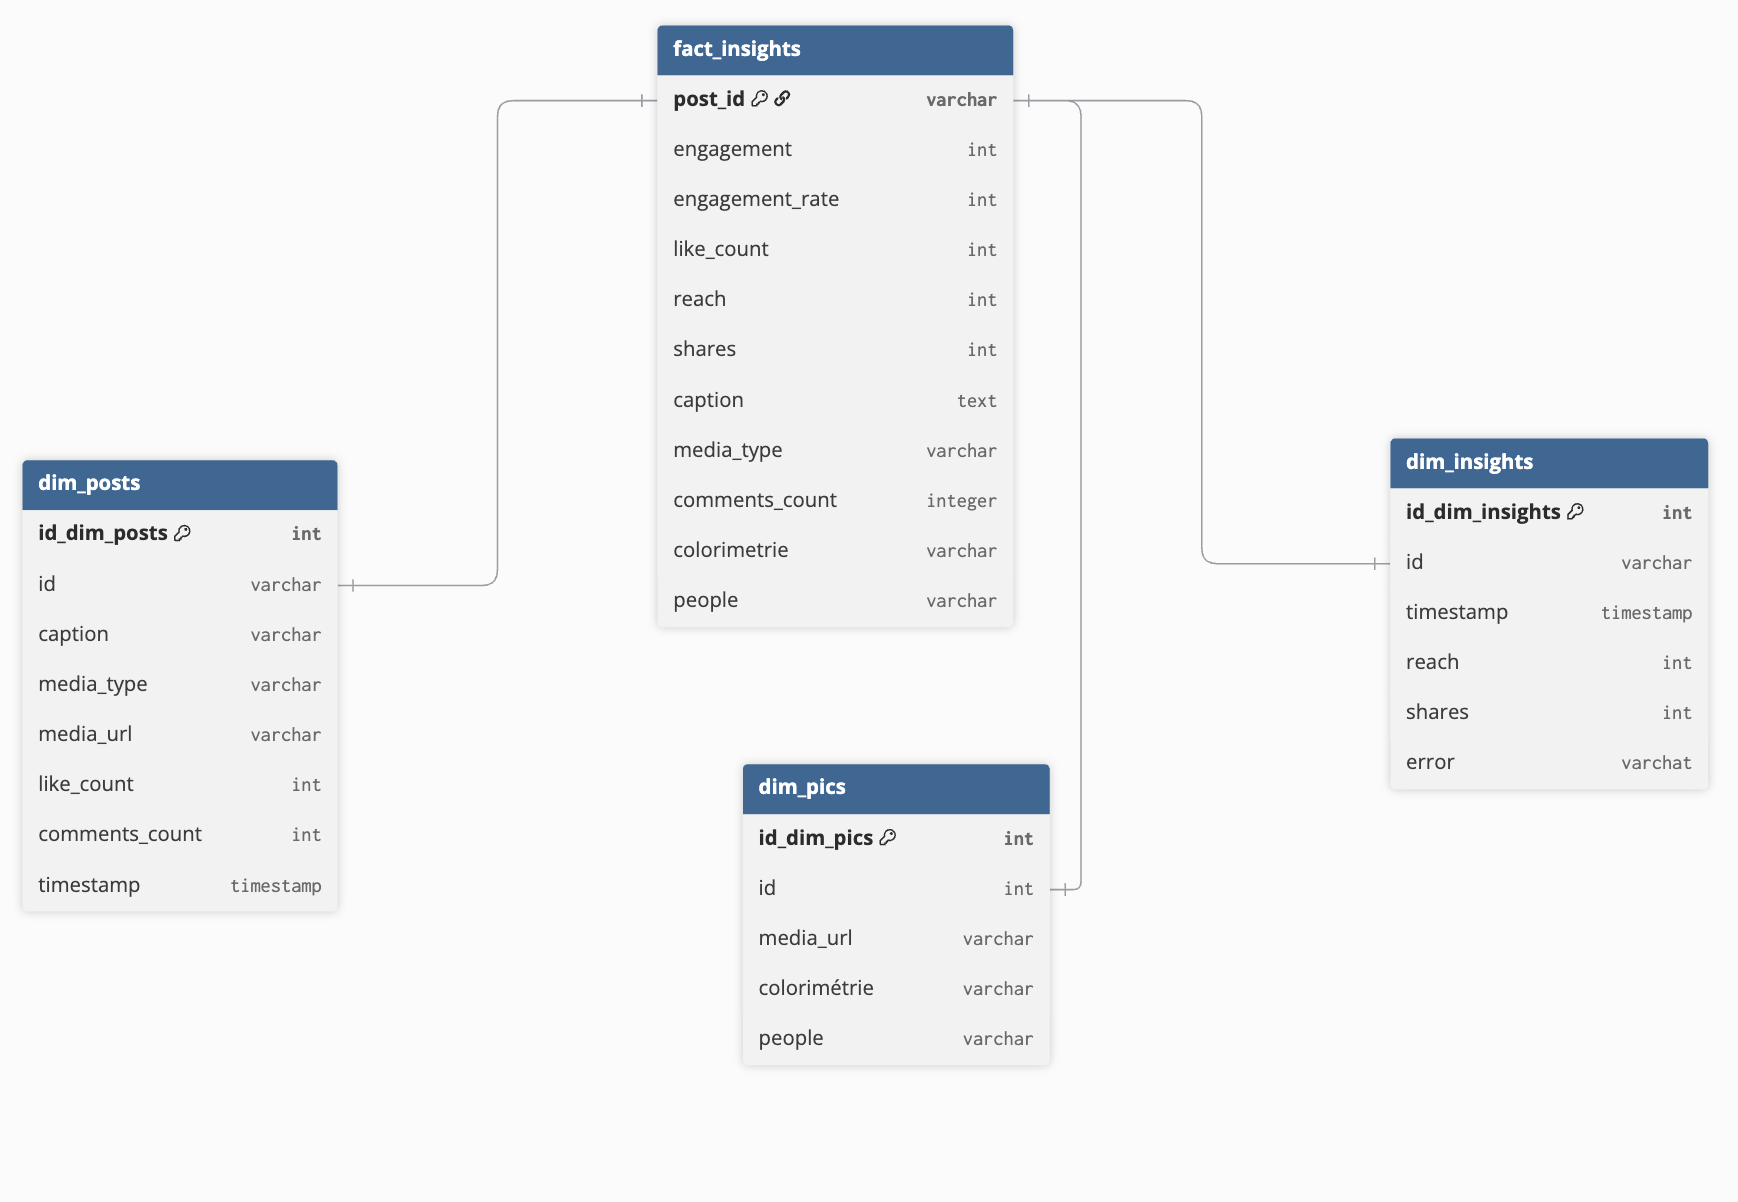
### RAW : ingestion des fichiers CSV extraits du notebook vers les 3 tables dim_pics, dim_insights et dim_posts

In [ ]:
-- SQL code to create tables in the RAW schema
CREATE TABLE "RAW".dim_posts (
    id_dim_posts SERIAL PRIMARY KEY,
    id VARCHAR(255),
    caption TEXT,
    media_type VARCHAR(50),
    media_url TEXT,
    like_count INTEGER,
    comments_count INTEGER,
    timestamp TIMESTAMP
);

CREATE TABLE "RAW".dim_insights (
  id_dim_insights int PRIMARY KEY,
  id VARCHAR(255),
  timestamp varchar,
  reach int,
  shares int,
  error varchar
);

CREATE TABLE "RAW".dim_pics (
  id_dim_pics int PRIMARY KEY,
  id VARCHAR(255),
  media_url TEXT,
  colorimétrie varchar,
  people varchar
);
-- SQL code to load data into the RAW schema tables from CSV files
\\copy \"RAW\".dim_insights (id_dim_insights, id, \"timestamp\", reach, shares, error) FROM '/Users/piotrgrudzinski/Documents/Projets/Projets 2025/16 - Jedha DAFS bootcamp/Bloc 6/Schema/RAW/dim_insights.csv' DELIMITER ',' CSV HEADER ;""
\\copy \"RAW\".dim_insights (id_dim_insights, id, \"timestamp\", reach, shares, error) FROM '/Users/piotrgrudzinski/Documents/Projets/Projets 2025/16 - Jedha DAFS bootcamp/Bloc 6/Schema/RAW/dim_insights.csv' DELIMITER ',' CSV HEADER ;""
\\copy \"RAW\".dim_posts (id_dim_posts, id, caption, media_type, media_url, like_count, comments_count, \"timestamp\") FROM '/Users/piotrgrudzinski/Documents/Projets/Projets 2025/16 - Jedha DAFS bootcamp/Bloc 6/Schema/RAW/dim_posts.csv' DELIMITER ',' CSV HEADER ;""


### Staging : Création des 3 vues filtrés et aux colonnes dédoublonnées

In [ ]:
CREATE VIEW "STAGING".dim_posts AS SELECT
    id_dim_posts,
    id AS postid,
    caption,
    media_type,
    media_url,
    like_count,
    comments_count,
    timestamp
FROM "RAW".dim_posts
WHERE media_type = 'CAROUSEL_ALBUM' OR media_type = 'IMAGE'


CREATE VIEW "STAGING".dim_pics AS SELECT
    id_dim_pics,
    id AS postid,
    colorimétrie,
    people
FROM "RAW".dim_pics


CREATE VIEW "STAGING".dim_insights AS SELECT
	id_dim_insights,
	id AS postid,
	reach,
	shares
FROM "RAW".dim_insights 
	


### CTE et jointure et deestiné au machine learning

In [ ]:
-- Active: 1767112096731@@6.tcp.eu.ngrok.io@12831@aitmp@DECISIONNEL
CREATE OR REPLACE VIEW "MACHINELEARNING".fact_insight AS 
(WITH dim_posts AS
(
    SELECT
    id_dim_posts,
    id AS dim_posts_postid,
    caption,
    media_type,
    media_url,
    like_count,
    comments_count,
    timestamp
	FROM "RAW".dim_posts
WHERE media_type = 'CAROUSEL_ALBUM' OR media_type = 'IMAGE'
),
dim_insights AS
(
    SELECT
	id_dim_insights,
	id AS dim_insights_postid,
	reach,
	shares
FROM "RAW".dim_insights 
),
dim_pics AS
(
    SELECT
    id_dim_pics,
    id AS dim_pics_postid,
    colorimétrie,
    people
FROM "RAW".dim_pics
)
SELECT dim_posts_postid as postid, caption, media_type, media_url, like_count,timestamp, colorimétrie, people, reach, shares
FROM dim_insights
JOIN dim_posts ON dim_posts_postid = dim_insights_postid
JOIN dim_pics ON dim_posts_postid = dim_pics_postid
);

In [ ]:
SELECT * from "MACHINELEARNING".fact_insight LIMIT 25;

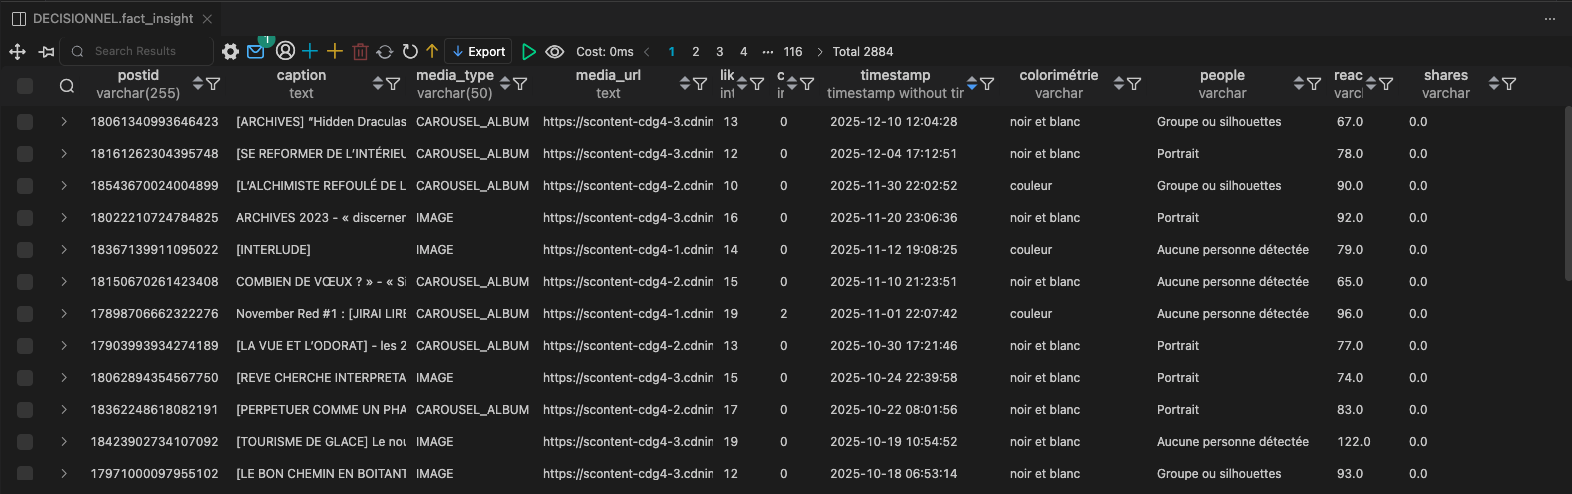

### CTE et jointure et destinée à l'ANALYTICS : champs de calculs et de saisonalité

In [ ]:
CREATE OR REPLACE VIEW "ANALYTICS".fact_insight AS
(
WITH dim_posts AS (
    SELECT
        id_dim_posts,
        id AS dim_posts_postid,
        COUNT(id) AS numberofposts,
        media_type,
        media_url,
        SUM(like_count) AS total_like_count,
        SUM(comments_count) AS total_likes_comments,
        timestamp,
        CASE
            WHEN EXTRACT(HOUR FROM timestamp) BETWEEN 18 AND 23 THEN 1
            ELSE 0
        END AS evening,
        CASE
            WHEN EXTRACT(HOUR FROM timestamp) BETWEEN 6 AND 12 THEN 1
            ELSE 0
        END AS morning,
        CASE
            WHEN EXTRACT(HOUR FROM timestamp) BETWEEN 12 AND 18 THEN 1
            ELSE 0
        END AS afternoon,
        CASE
            WHEN EXTRACT(HOUR FROM timestamp) BETWEEN 23 AND 6 THEN 1
            ELSE 0
        END AS night,
        CASE
            WHEN EXTRACT(MONTH FROM timestamp) IN (3,4,5) THEN 1
            ELSE 0
        END AS spring,
        CASE
            WHEN EXTRACT(MONTH FROM timestamp) IN (6,7,8) THEN 1
            ELSE 0
        END AS summer,
        CASE
            WHEN EXTRACT(MONTH FROM timestamp) IN (9,10,11) THEN 1
            ELSE 0
        END AS autumn,
        CASE
            WHEN EXTRACT(MONTH FROM timestamp) IN (12,1,2) THEN 1
            ELSE 0
        END AS winter
    FROM "RAW".dim_posts
    WHERE media_type = 'CAROUSEL_ALBUM' OR media_type = 'IMAGE'
    GROUP BY
        id_dim_posts,
        id,
        media_type,
        media_url,
        timestamp
),
dim_insights AS (
    SELECT
        id_dim_insights,
        id AS dim_insights_postid,
        SUM(CAST(reach AS INTEGER)) AS numberofreach,
        SUM(CAST(shares AS INTEGER)) AS numberofshares
    FROM "RAW".dim_insights
    GROUP BY
        id_dim_insights,
        id
),
dim_pics AS (
    SELECT
        id_dim_pics,
        id AS dim_pics_postid,
        colorimétrie,
        people
    FROM "RAW".dim_pics
)
SELECT
    dim_posts_postid AS postid,
    caption,
    media_type,
    media_url,
    like_count,
    timestamp,
    numberofposts,
    colorimétrie,
    people,
    numberofreach,
    numberofshares,
    winter,
    autumn,
    summer,
    spring,
    night,
    afternoon,
    morning,
    evening
FROM dim_insights
JOIN dim_posts ON dim_posts_postid = dim_insights_postid
JOIN dim_pics ON dim_posts_postid = dim_pics_postid
);


In [ ]:
SELECT * from "ANALYTICS".fact_insight LIMIT 25;

### CTE et jointure et destinée au MACHINE LEARNING : données à plat sans calculs

In [ ]:
CREATE OR REPLACE VIEW "MACHINELEARNING".fact_insight AS 
(WITH dim_posts AS
(
    SELECT
    id_dim_posts,
    id AS dim_posts_postid,
    caption,
    media_type,
    media_url,
    like_count,
    comments_count,
    timestamp
	FROM "RAW".dim_posts
WHERE media_type = 'CAROUSEL_ALBUM' OR media_type = 'IMAGE'
),
dim_insights AS
(
    SELECT
	id_dim_insights,
	id AS dim_insights_postid,
	reach,
	shares
FROM "RAW".dim_insights 
),
dim_pics AS
(
    SELECT
    id_dim_pics,
    id AS dim_pics_postid,
    colorimétrie,
    people
FROM "RAW".dim_pics
)
SELECT dim_posts_postid as postid, caption, media_type, media_url, like_count,timestamp, colorimétrie, people, reach, shares
FROM dim_insights
JOIN dim_posts ON dim_posts_postid = dim_insights_postid
JOIN dim_pics ON dim_posts_postid = dim_pics_postid
);

In [ ]:
Select * from "MACHINELEARNING".fact_insight LIMIT 25;

# ANALYTICS : outil Lookerstudio
## but : produire des visualisations pour illustrer les principales tendances des posts instagram
## Définitions : 
| Name | Nom fr | Explication |
| --- | --- | --- |
| reach | Impressions | Le nombre de comptes uniques qui ont vu cette publication |
| likes | J'aime | Le nombre de J’aime sur votre publication. |


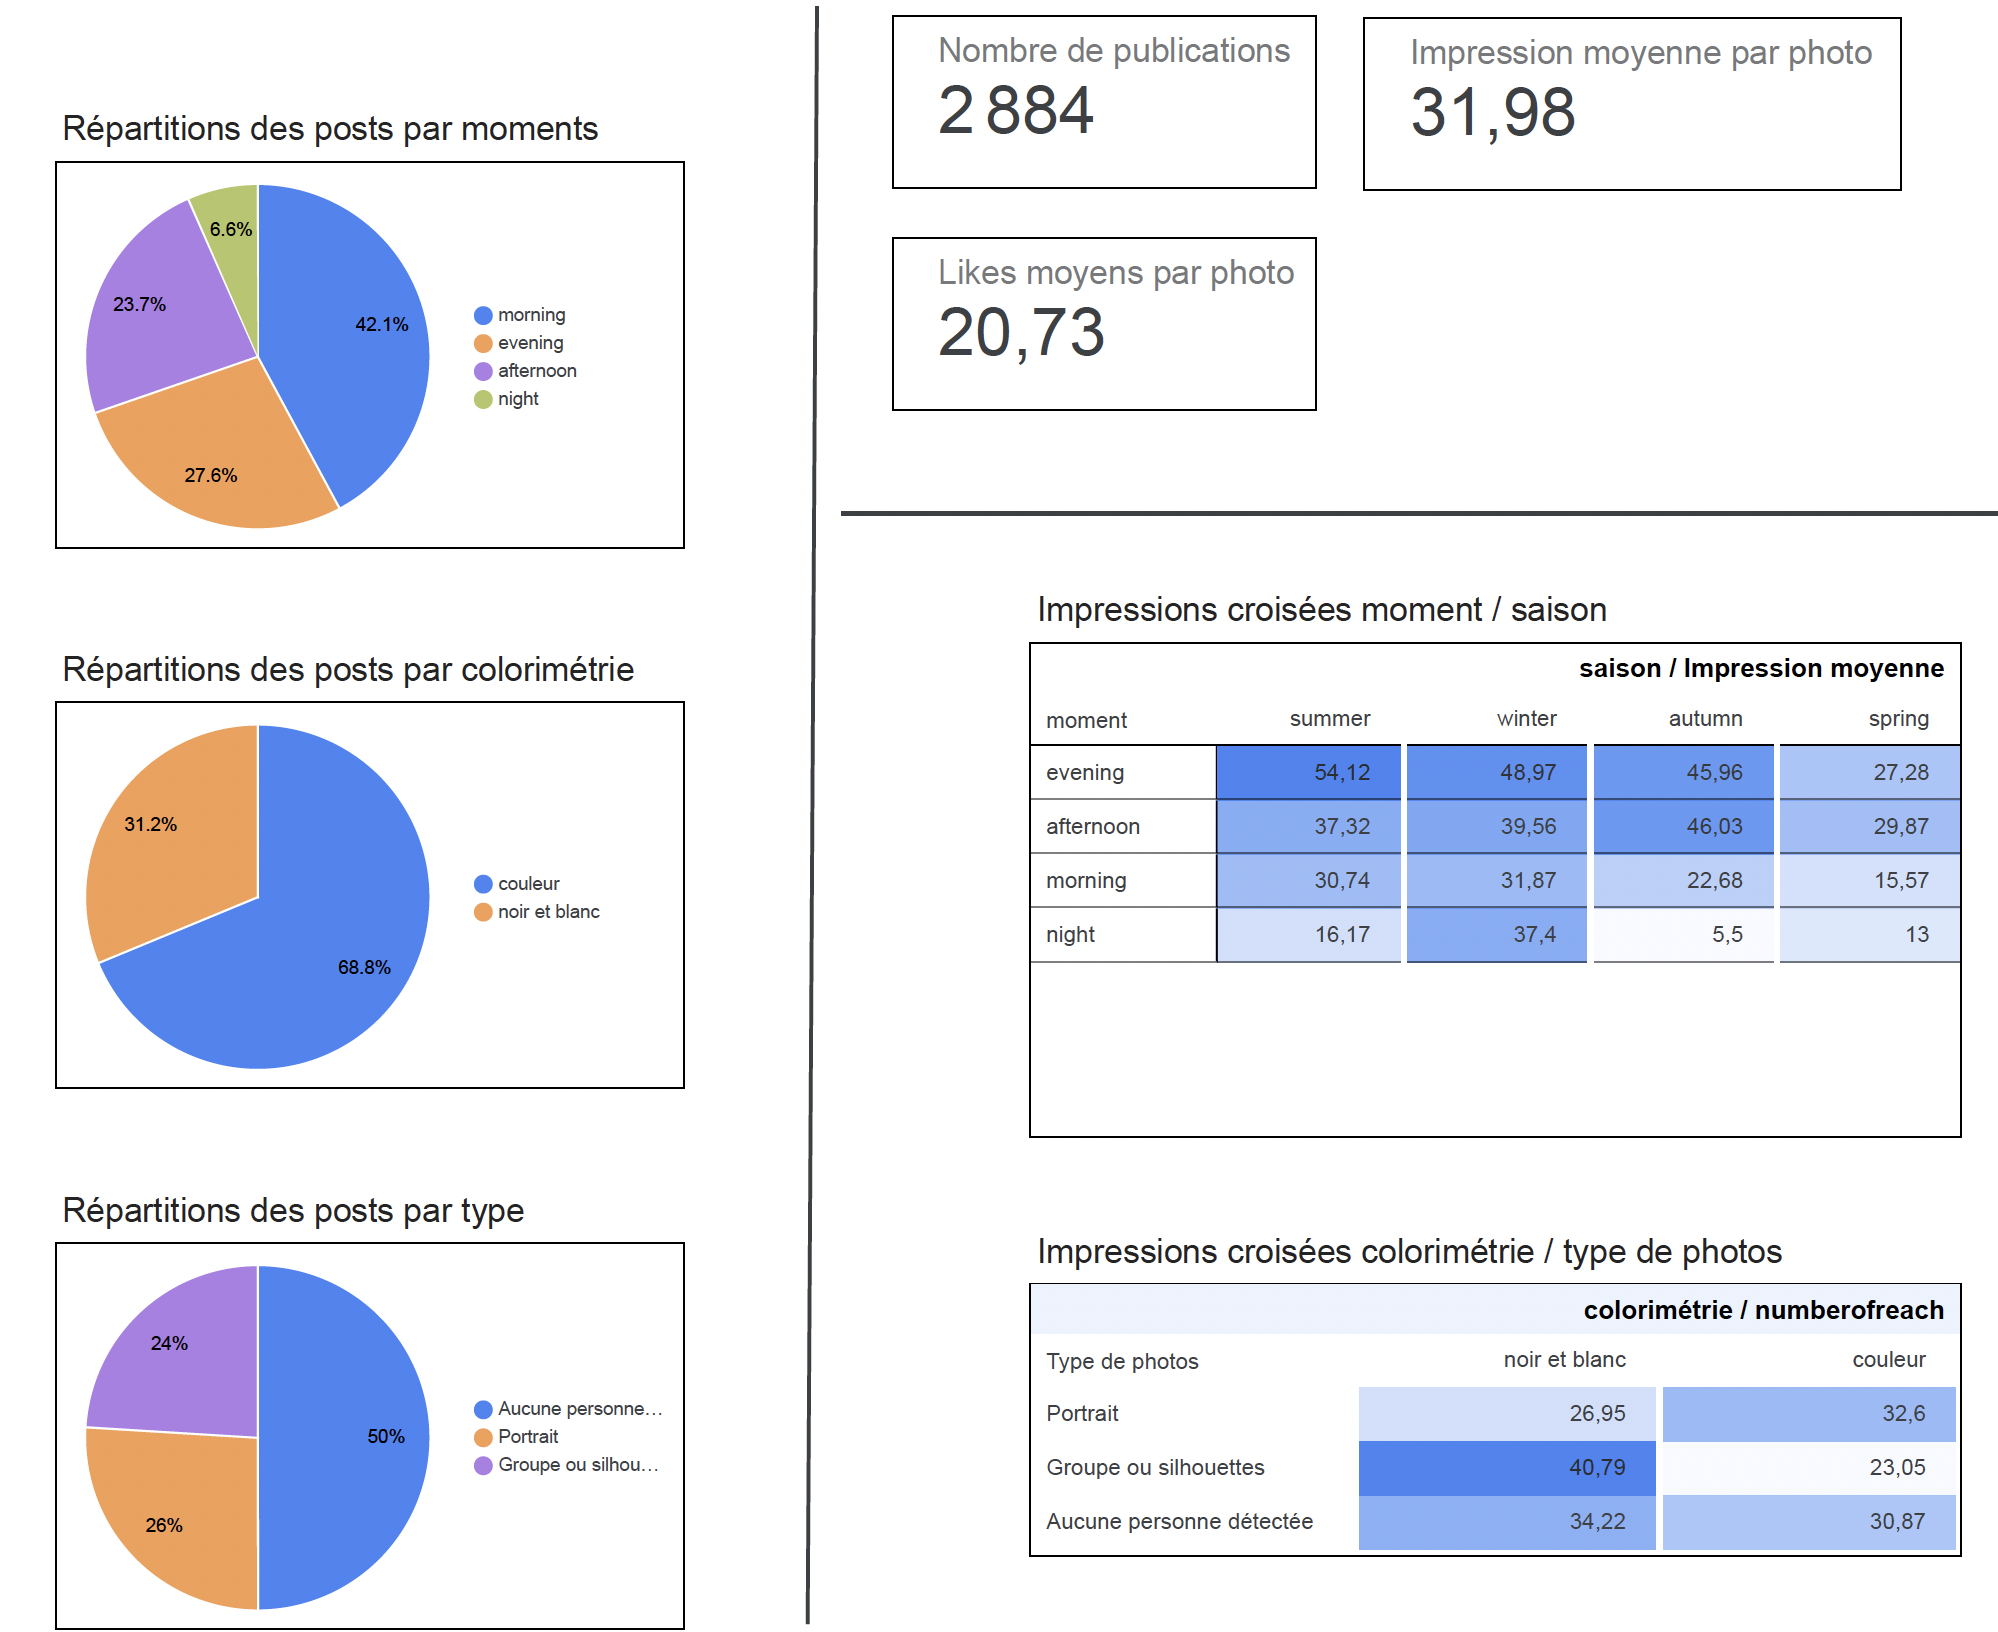
### Enseignements 
#### Afin d'améliorer les performances de ce compte instagram,  on peut donc suggérer une nouvelle stratégie de réseaux sociaux : 
#### - lesphotos en noir et blanc et contenant des groupes ou des silouhettes ont des meilleures performances (impressions)
#### - il vaut mieux poster le soir (sauf l'automne ou l'AM est un meilleur créneau)

# Machine Learning (outil Dataiku)
## but : entrainer ces données et prédire le score de viralité d'une photo

### Connecter Dataiku avec PostGreSQL
#### via un tunnel SSL
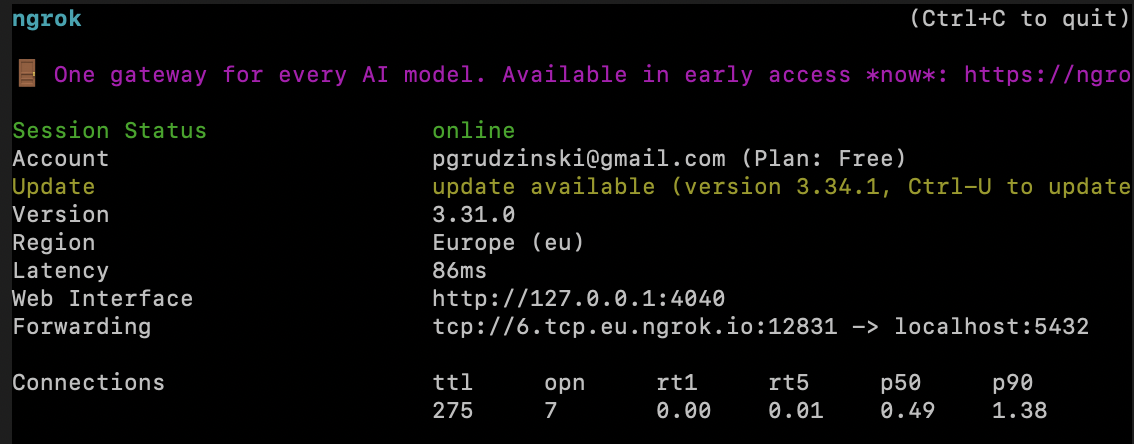
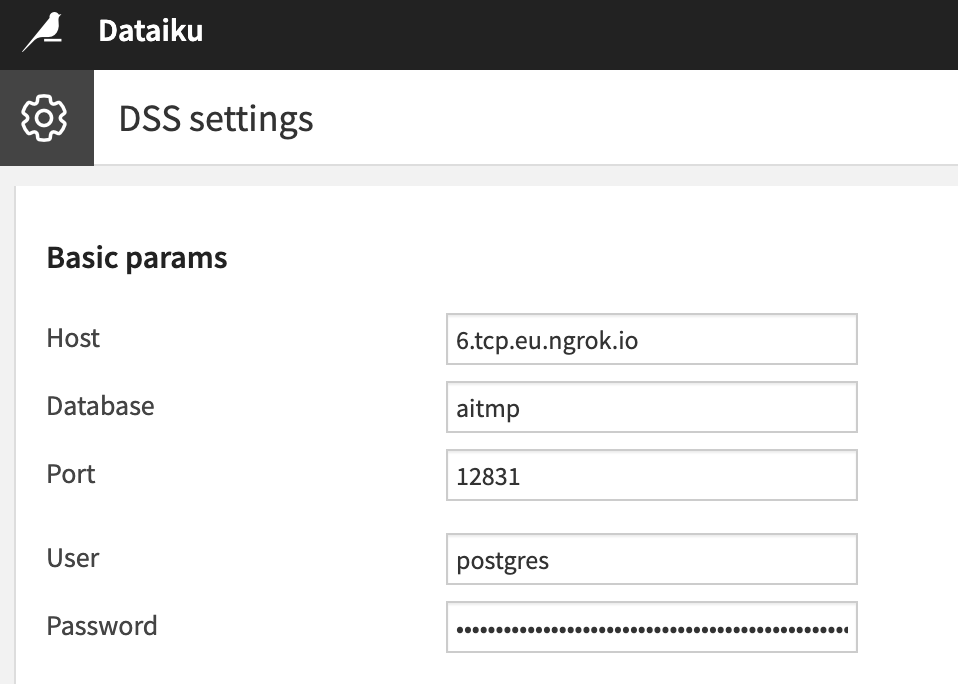

### La MACHINELEARNING.FACT INSIGHTS est récupérée
### on peut approfondir l'EDA pour contrôler la qualité des données
### ici, les colonnes REACH et SHARE, critiques pour le score de viralité, sont partiellement remplies
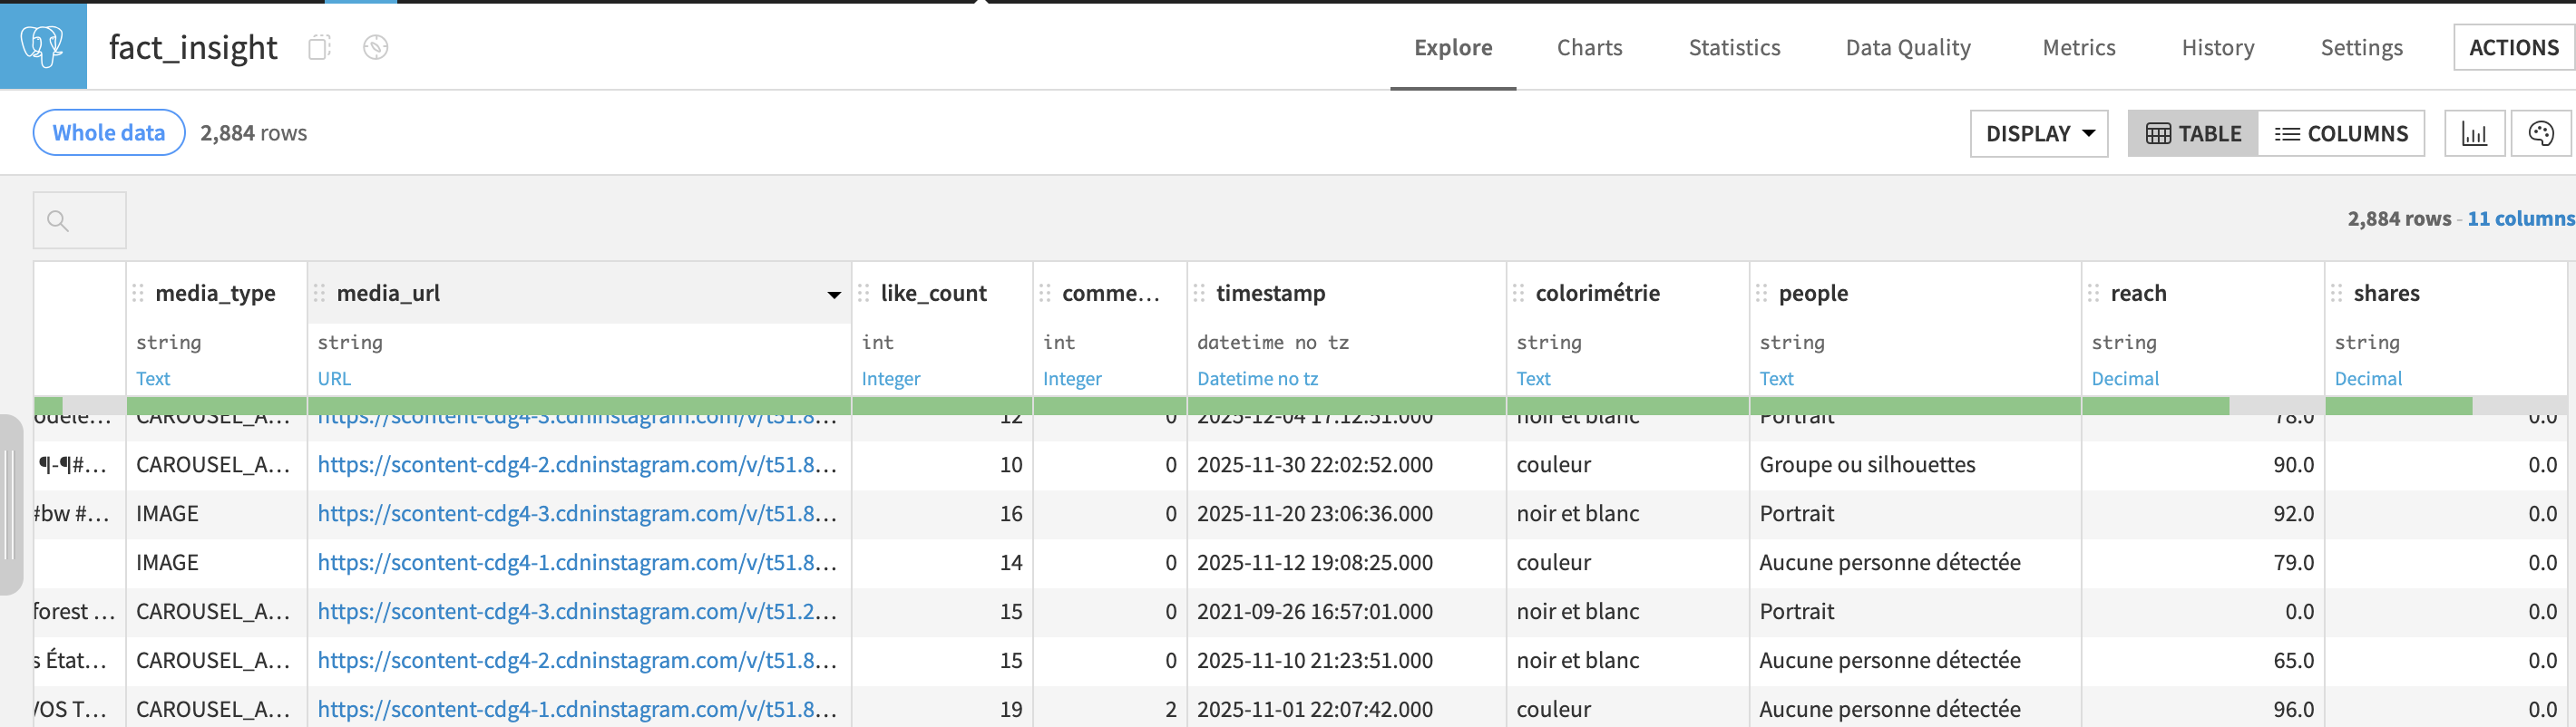
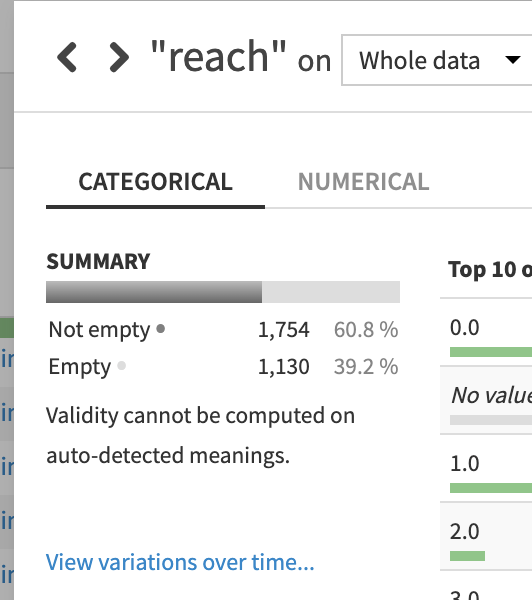

### Explications : Instagram ne mesure ces 2 données depuis 2019
### nous verrons comment nous allons alimenter ces données plus tard

## La pipeline avant d'entrainter les données
### Elle va permettre de faire du feature engineering et de créer le champ à prédire (score de viralité)
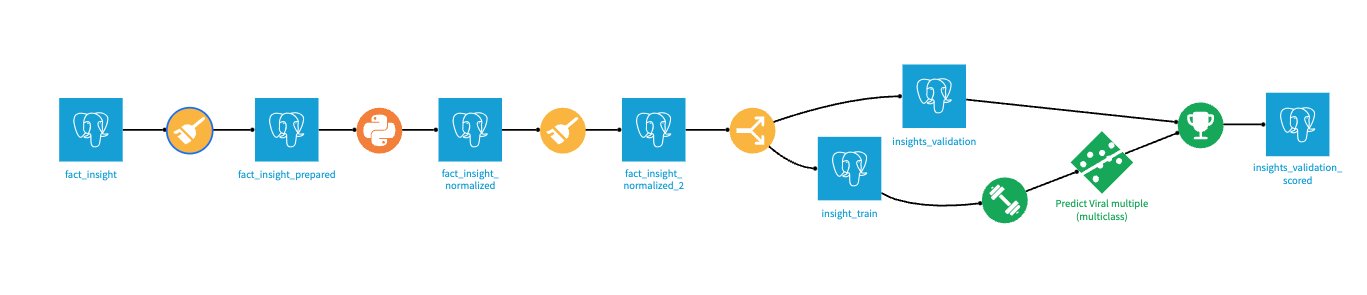

### Fact insight --> fact insight prepared
#### feature engineering avec la créaton des colonnes "saison" et "moment" après avoir extrait les mois et heures
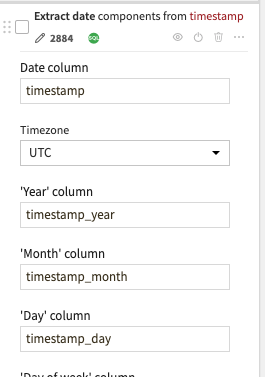
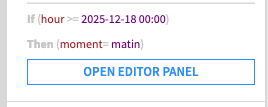
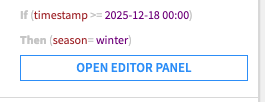

#### nettoyage des hashtags dans "caption"

### Fact insight prepapred --> fact insight normalized
#### c'est ici que nous allons compléter les données manquantes de Reach (shares ne sera pas utilisé finalement)
#### pour cela fonction Python inséré via le plugin Dataiku qui va enrichir cette donnée à partir des Likes

1. il va récupérer les moyennes, écart type et médian des likes et reach
2. on va appliquer un coefficient 0.7 sur les likes pour estimer le nombre de reach

    
def estimer_reach_normalise(likes):

    return normaliser_likes(likes) * 0.7 
    
    reach_estime = estimer_reach_normalise(row['like_count'])

3. on va aussi additionner avec les valeurs de 1. comme ceci : 

        reach_proxy = reach_estime * reach_std + reach_mean

3. on va enrichir le dataset avec les valeurs ainsi calculés
#### distribution avant et après enrichissement
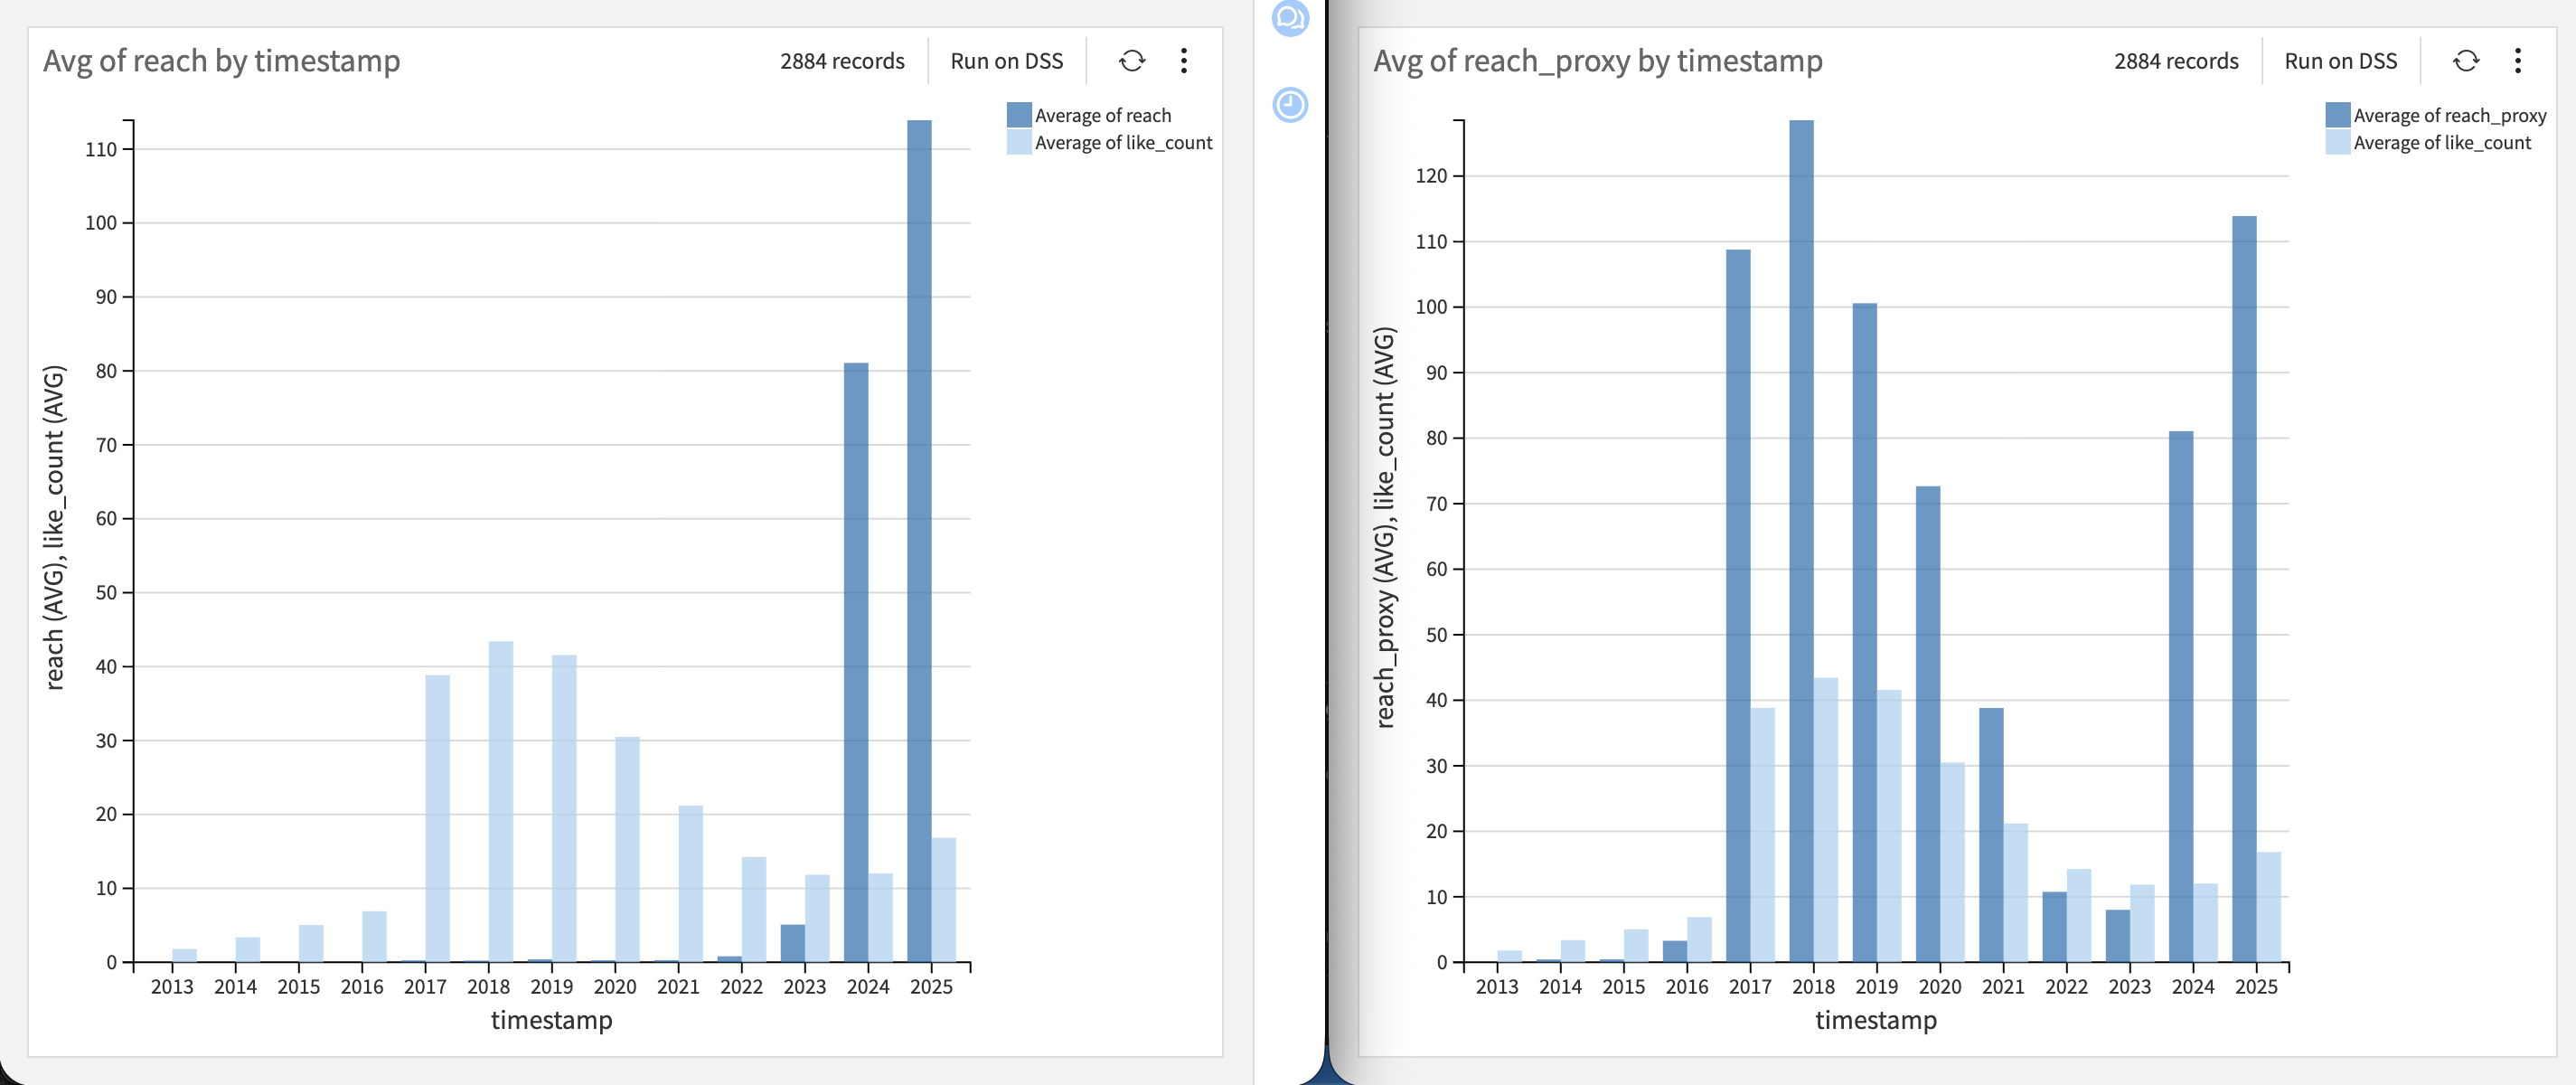

In [ ]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

# Read recipe inputs
fact_insight_prepared = dataiku.Dataset("fact_insight_prepared")
fact_insight_prepared_df = fact_insight_prepared.get_dataframe()

# Paramètres de normalisation pour les likes (basés sur votre distribution)
likes_mean = 20.185970
likes_std = 17.701201
likes_median = 15

# Paramètres de normalisation pour le reach (à ajuster selon vos données)
reach_mean = 18.269108 # Moyenne des reach disponibles
reach_std = 118.314263   # Écart-type des reach disponibles

# Fonction pour normaliser les likes
def normaliser_likes(likes):
    return (likes - likes_median) / likes_std

# Fonction pour estimer le reach normalisé à partir des likes
def estimer_reach_normalise(likes):
    return normaliser_likes(likes) * 0.7  # Coefficient empirique (ajustable)

# Fonction pour calculer le reach proxy
def calculer_reach_proxy(row):
    if pd.isna(row['reach']) or row['reach'] == 0:
        # Estimer le reach normalisé à partir des likes
        reach_estime = estimer_reach_normalise(row['like_count'])
        # Dénormaliser pour obtenir une valeur de reach estimée
        reach_proxy = reach_estime * reach_std + reach_mean
        return max(0, reach_proxy)  # Éviter les valeurs négatives
    else:
        return row['reach']

# Appliquer la fonction pour calculer le reach proxy
fact_insight_prepared_df['reach_proxy'] = fact_insight_prepared_df.apply(calculer_reach_proxy, axis=1)

# Sauvegarder le dataset de sortie
output_dataset = dataiku.Dataset("fact_insight_normalized")  # Remplacez par le nom de votre output
output_dataset.write_with_schema(fact_insight_prepared_df)

### Fact insight normalized --> fact insight normalized 2 : création du score de viralité
#### un bon score de viralité doit faire le rapport entre le nombre de likes  et le nombre de reach, pondéré avec les valeurs  est le suivant 
score de viralité = (like_count - mediane) / ecart type + (reach_proxy - mediane) / ecart type

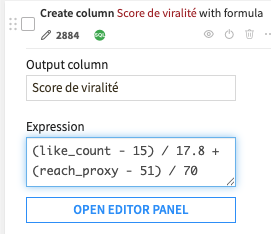
#### Grâce à cette pondération de normalisation, chaque métrique (like_count et reach) est centrée sur sa médiane et divisée par son écart-type. Cela permet de les comparer sur une même échelle (standardisation en Z-score).

#### on va ensuite rendre ce score multidimentionnel  limité à 4 valeurs pour simplifier sa prédiction

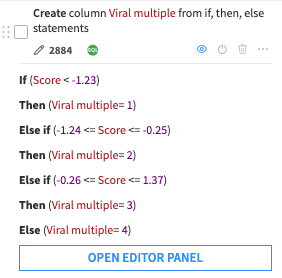


### Split de la dataset en données d'entraintement et données de validation
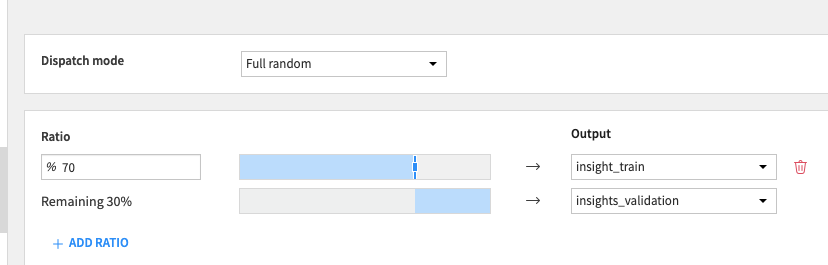

### Lancement de quelques modèles de ML afin de connaitre le meilleur pour scorer "score de viralité)
#### au bout de qelques tests, l'algorithme Random Forest associé à la metri "ROC AUC" semble être la plus performante
1. les features sélctionnés : enlever ceux qui ont un lien direct avec le score (comme likes)

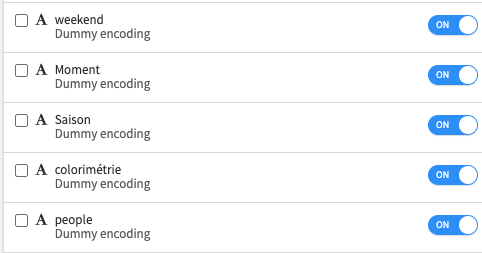

2. choisir une profondeur de décision assez grosse 

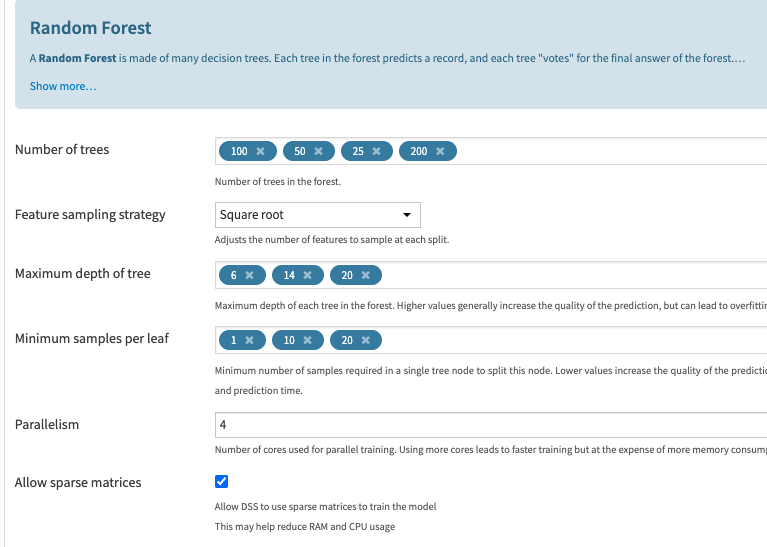

3. résultat : score de 0.733 , ce qui pour du marketing ou de la reco est acceptable

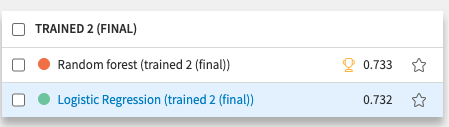

4. les features les plus importants : la colorimétrie et le moment de la journée ont le plus d'influence sur le bon score de viralité d'une photo

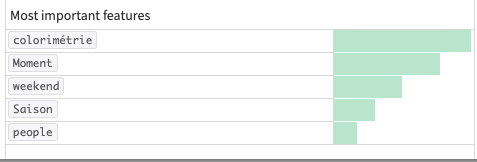


### Scoring de la données à prédire

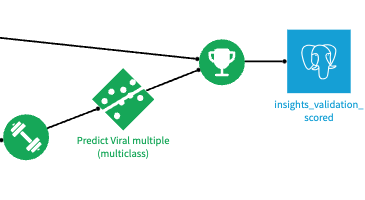

On va donc prédire le champ "Viral multiple" dans le champ "prédiction" sur la donnée servant à valider le modèle 

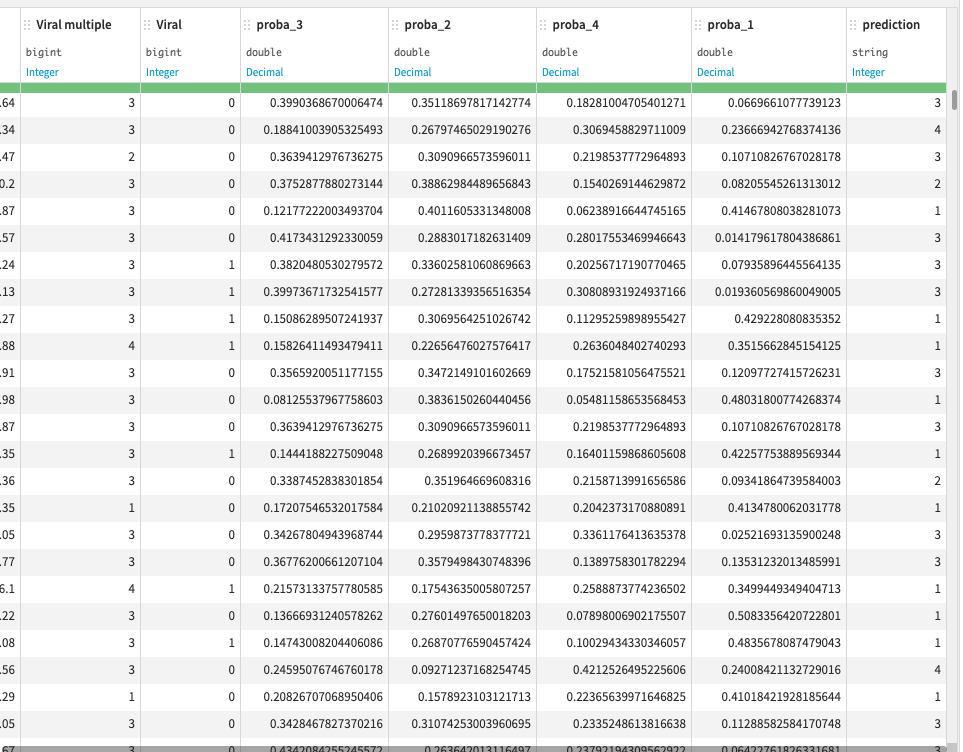